# San Diego Real Estate Analysis

The data was gathered by scraping the Zillow website. Zillow is a listing service which shows all kinds of property being sold by real estate agents. This includes empty lots, homes, apartments, and forclosed properties. This information is in the `sale_type` field.

It should be noted that the homes on zillow are all for sale and no actual sale data was gathered. This means that the sample only represents the sellers of homes in San Diego rather than the market as a whole. 

Each datapoint has the following fields: 
* `address`
* `city`
* `state`
* `zip`
* `price`
* `sqft`
* `bedrooms`
* `bathrooms`
* `days_on_zillow`
* `sale_type`
* `url`


In [1]:
# Imports are pretty straight forward.
# CSV parser, numpy for working with number lists, and matplotlib for visualizations.

import csv
import numpy as np
import matplotlib.pyplot as plt
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

The CSV file is formatted as follows:

|address|city|state|zip|price|sqft|bedrooms|bathrooms|days_on_zillow|sale_type|url|
|-|-|-|-|-|-|-|-|-|-|-|
|2100 Rebecca Way|Lemon Grove|CA|91945|449000|1507.0|3.0|3.0|NA|House For Sale|http://www.zillow.com/homes/for_sale//homedetails/2100-Rebecca-Way-Lemon-Grove-CA-91945/80620236_zpid/|
|2130 Eldora St|Lemon Grove|CA|91945|429000|1532.0|3.0|2.0|NA|House For Sale|http://www.zillow.com/homes/for_sale//homedetails/2130-Eldora-St-Lemon-Grove-CA-91945/17113419_zpid/|

In [2]:
listings = []
with open('composition.csv') as data:
    reader = csv.DictReader(data, delimiter=',')
    for row in reader:
        listings.append(row)

In [3]:
# Some listings do not have an associated price, this function will 
# simply make the script more legible within filter functions.

def has_price(listing):
    return listing['price'] != 'NA'

In [4]:
# Inline import statements aren't conventional but the formatter import is obscure. 
# The following block of code creates some functions which make formatting of the graphs easier to read.

from matplotlib.ticker import FuncFormatter

def millions(x, pos):
    'The two args are the value and tick position'
    return '$%.1fM' % (x*1e-6)

def thousands(x, pos):
    'The two args are the value and tick position'
    return '$%.1f' % (x*1e-5)

def formaty_mil(plot):
    fig, ax = plot.subplots()
    ax.yaxis.set_major_formatter(FuncFormatter(millions))

def formatx_mil(plot):
    fig, ax = plot.subplots()
    ax.xaxis.set_major_formatter(FuncFormatter(millions))

def formaty_100k(plot):
    fig, ax = plot.subplots()
    ax.yaxis.set_major_formatter(FuncFormatter(thousands))
    
def formatx_100k(plot):
    fig, ax = plot.subplots()
    ax.xaxis.set_major_formatter(FuncFormatter(thousands))
    

# Prices

Price data can be visualized and analyzed in several ways. The simplest is a sigle boxplot of all the collected data. This allows for a general overview of data before getting to deep into the specifics. In the case of our data, the box plot was shocking, showing enourmous range in the top quartile. A histogram is another simple way of getting a feel for the dataset and more revealing in showing where most of the datapoints exist.

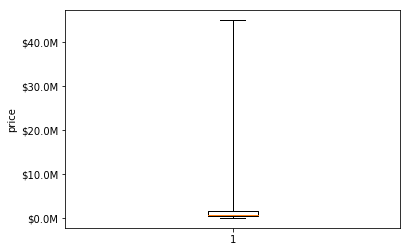

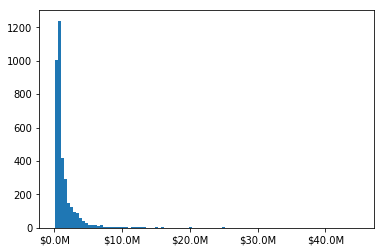

In [5]:
# get all prices that exist
all_prices = [float(listing['price']) for listing in listings if has_price(listing)]

# box
formaty_mil(plt)
plt.boxplot(all_prices, whis='range')
plt.ylabel('price')
plt.show()

# hist
formatx_mil(plt)
plt.hist(all_prices, 100)
plt.show()

The box plot highlights the range of the data, while the histogram highlights the body of the data. Together it is possible to see that while the range is great, the majority of the data lies quite low. For curiousity the ouling house with the maximum price can be seen [here](https://www.zillow.com/homes/for_sale//homedetails/17111-El-Vuelo-Rancho-Santa-Fe-CA-92067/16732045_zpid/) and has the following fields:

In [6]:
def search_by_price(price):
    ret = []
    for listing in listings:
        if has_price(listing) and float(listing['price']) == price:
            ret.append(listing)
    return ret

search_by_price(max(all_prices))

[OrderedDict([('address', '17111 El Vuelo'),
              ('city', 'RANCHO SANTA FE'),
              ('state', 'CA'),
              ('zip', '92067'),
              ('price', '44975000'),
              ('sqft', '23500.0'),
              ('bedrooms', '6.0'),
              ('bathrooms', '11.0'),
              ('days_on_zillow', 'NA'),
              ('sale_type', 'House For Sale'),
              ('url',
               'http://www.zillow.com/homes/for_sale//homedetails/17111-El-Vuelo-Rancho-Santa-Fe-CA-92067/16732045_zpid/')])]

## Making Data Relevant

These graphs aren't very helpful so the outling values need to be removed. In order to get a numerical idea of normal house, we calculated the median, mean, and standard deviation. These values can be used to find filter irrelevant data. However, in doing so the sample no longer represents the population. That is not to say the sample won't be useful in making conclusions, it just requires scruitiny. 

In [7]:
# convert the array of prices to numpy for future continuity
all_prices = np.array(all_prices)

# median since we're here
price_median = np.median(all_prices)
print('median: ${:,}'.format(price_median))
# mean using numpy
price_mean = np.mean(all_prices)
print('mean: ${:,.0f}'.format(price_mean))
# std dev using numpy
price_stddev = np.std(all_prices)
print('stddev: ${:,.0f}'.format(price_stddev))

median: $734,450.0
mean: $1,425,830
stddev: $2,221,362


Now that we know this we can make some conclusions on the outling point by finding its distance from the mean in standard deviations:

In [8]:
# calculate how many standard deviations the house on El Vuelo is from the mean
dev_of_max = (max(all_prices) - price_mean) / price_stddev
print('stddev of maximum: {:f}'.format(dev_of_max))

stddev of maximum: 19.604716


And that it is an *extreme* outlier. The next step in making the data relevant and more useable is to cut off the outliers. This can be done in several ways. In the case of a real estate agent, they might remove any homes with values outside the client's price range. In this case we don't have a price range, but rather just trying to make the data more palletable, like the standard normal curve. The biggest issue with the current sample is that there are no values more than one standard deviation to the left of the mean, while there is a value almost 20 standard deviations to the right of the mean. To solve this, values can be excluded from the top end of the data set.

But how much?

In [9]:
# sort the prices
all_prices = np.sort(all_prices)

for i in [0.99, 0.95, 0.9, 0.85, 0.8, 0.75]:
    trimed_prices = all_prices[:int(len(all_prices)*i)]
    #make i a percent
    i = i * 100
    
    print("bottom {:.0f}%".format(i))
    # max
    price_max = max(trimed_prices)
    print('max: ${:,}'.format(price_max))
    # min
    price_min = min(trimed_prices)
    print('min: ${:,}'.format(price_min))
    # median
    price_median = np.median(trimed_prices)
    print('median: ${:,}'.format(price_median))
    # mean using numpy
    price_mean = np.mean(trimed_prices)
    print('mean: ${:,.0f}'.format(price_mean))
    # std dev using numpy
    price_stddev = np.std(trimed_prices)
    print('stddev: ${:,.0f}\n'.format(price_stddev))

bottom 99%
max: $10,500,000.0
min: $30,000.0
median: $720,870.0
mean: $1,269,896
stddev: $1,430,298

bottom 95%
max: $4,550,000.0
min: $30,000.0
median: $695,000.0
mean: $1,049,175
stddev: $910,590

bottom 90%
max: $3,185,000.0
min: $30,000.0
median: $660,000.0
mean: $899,341
stddev: $663,637

bottom 85%
max: $2,399,000.0
min: $30,000.0
median: $639,000.0
mean: $792,673
stddev: $508,234

bottom 80%
max: $1,825,000.0
min: $30,000.0
median: $599,999.0
mean: $711,293
stddev: $400,505

bottom 75%
max: $1,499,000.0
min: $30,000.0
median: $579,000.0
mean: $648,457
stddev: $327,167



Looks like the bottom 75% will give a pretty normal looking curve with almost two standard deviations of space below the mean. Once again, this graph only makes the data more readable to the average buyer and focuses attention to the bulk of the data.

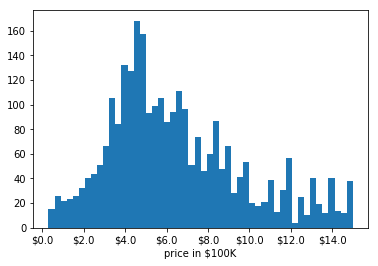

In [10]:
trimed_prices = all_prices[:int(len(all_prices)*0.75)]
formatx_100k(plt)

plt.hist(trimed_prices, 50)
plt.xlabel('price in $100K')
plt.show()

Another thing to note is that these graphs are simply looking at price, which can be decieving as many factors go into the price. The most commonly referenced factors of price are location and square footage which will be looked at next.

## Zip code

Once again, the first step will be box-plots. This time, not out of simplicity but rather out of effectiveness of comparing groups of data. Each zip code will recieve its own box-plot and they will be displayed adjacent to each other.

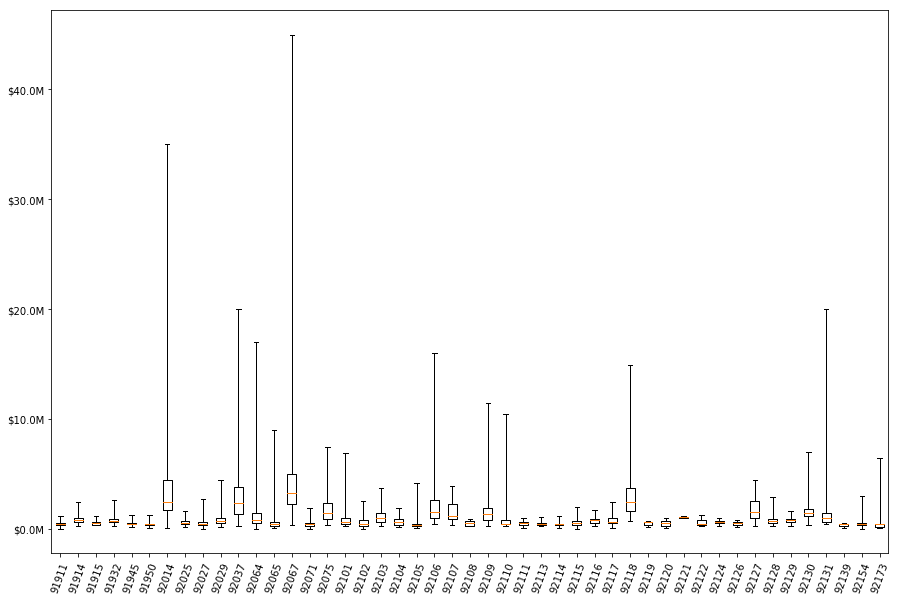

In [11]:
zip_price_dict = {}

# iterate listings populating lists for each zip code
for listing in listings:
    if has_price(listing):
        key = listing['zip']
        if key in zip_price_dict:
            zip_price_dict[key].append(float(listing['price']))
        else:
            zip_price_dict[key] = [float(listing['price'])]

# parallel lists
zips = []
prices = []
for k, v in sorted(zip_price_dict.items()):
    zips.append(k)
    prices.append(v)
    
# formatting
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.yaxis.set_major_formatter(FuncFormatter(millions))
plt.boxplot(prices, whis='range')
ax.set_xticklabels(zips)
plt.xticks(rotation=70)
plt.show()

Once again, the graph is saturated by high values. But now, it can be seen that the high outliers are coming from high valued neighborhoods. A real estate agent looking at this data might want to know where these zip codes are when trying to find work. Also, a homebuyer might want to avoid these areas when searching for a new home. The top three neighborhoods are no surprise to any San Diegan:

In [12]:
def search_by_zip(z):
    ret = []
    for listing in listings:
        if z == listing['zip']:
            ret.append(listing)
    return ret

# zip codes with top 3 outliers
for i in ['92067', '92014', '92037']:
    arr = search_by_zip(i)
    print(i, ': ', arr[0]['city'])

92067 :  Rancho Santa Fe
92014 :  Del Mar
92037 :  La Jolla


Once again, let's make trim the top of the data to get a better view of the main body. This time a simple price cap can be implemented since we know the maximum value of the `relevant` sample (~ $1.5 Mil). However, upon using a $1.5 Mil cap many of the boxplots looked the same. The following graph is using a $3 Mil cap.

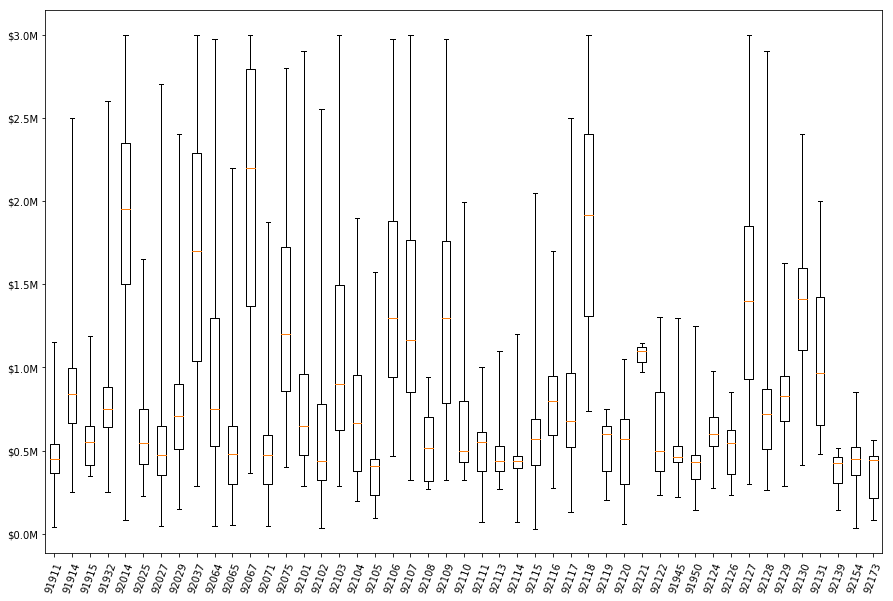

In [13]:
zip_price_dict = {}

# iterate listings populating lists for each zip code
for listing in listings:
    # filter prices above threshold
    if has_price(listing) and float(listing['price']) < 3e6:
        key = listing['zip']
        if key in zip_price_dict:
            zip_price_dict[key].append(float(listing['price']))
        else:
            zip_price_dict[key] = [float(listing['price'])]

# parallel lists
zips = []
prices = []
for k, v in zip_price_dict.items():
    zips.append(k)
    prices.append(v)
    
# formatting
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.yaxis.set_major_formatter(FuncFormatter(millions))
plt.boxplot(prices, whis='range')
ax.set_xticklabels(zips)
plt.xticks(rotation=70)
plt.show()

This visualization, while rough shows the relevant data in a more detailed fashion. We can quickly make the assumption that a majority of zip codes have a median price around \$500K, while also having maximums above \$1 Mil. Let's double check that:

In [14]:
# reuse the dict from above
zip_count = len(zip_price_dict)
print('zip count: ', zip_count)

med_close_to_500k = 0
max_over_mil = 0

for k in zip_price_dict:
    prices = zip_price_dict[k]
    if abs(np.median(prices) - 5e5) < 1e5:
        med_close_to_500k = med_close_to_500k + 1
    if max(prices) > 1e6:
        max_over_mil = max_over_mil + 1
print('median between $400K and $600K: ', med_close_to_500k, '({:.2f}%)'.format(med_close_to_500k/zip_count * 100))
print('max over $1 Mil: ', max_over_mil, '({:.2f}%)'.format(max_over_mil/zip_count * 100))
        

zip count:  47
median between $400K and $600K:  24 (51.06%)
max over $1 Mil:  39 (82.98%)


Just barely a majority for the median around $500k. But an astounding 87\% of zip codes in San Diego have million dollar homes. Although out of scope of this document, these figures can be used to compare cities.

## Square-footage

This field can be used in a few ways. 
* As a dependent variable with some input constraints such as price or number of bedrooms
* As an independent variable to get a feel for the price of house with desired size
* In the popular metric of dollars per square foot

We'll go through all of them.

The following viusualization will be used to represent a buyer's interest, in this case it will be more aparent than previous filters as the search criteria will be stricter.

We'll filter all houses which suit a buyer's necessity of 2 bedrooms and 3 bathrooms, and display the results in a histogram.

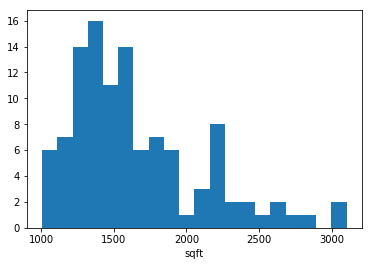

In [15]:
sqfts = []
# list notation too verbose
for listing in listings:
    if 'NA' in [listing['sqft'], listing['bedrooms'], listing['bathrooms']]:
        continue
    if float(listing['bedrooms']) == 2 and float(listing['bathrooms']) == 3:
        sqfts.append(float(listing['sqft']))

plt.hist(sqfts, 20)
plt.xlabel('sqft')
plt.show()

From this graph we can see that a 2 bedroom, 3 bath home will usually be around 1500 sqft. This might be handy when barganing and generally comparing homes when searching. While the focus is currently on zip codes, it should be noted that the same filtering methods can be used with price.

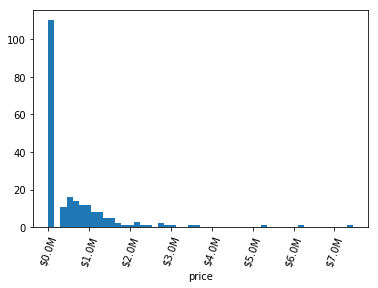

In [16]:
prices = []
# list notation too verbose
for listing in listings:
    if 'NA' in [listing['price'], listing['bedrooms'], listing['bathrooms']]:
        continue
    if float(listing['bedrooms']) == 2 and float(listing['bathrooms']) == 3:
        sqfts.append(float(listing['price']))

formatx_mil(plt)
plt.hist(sqfts, 50)
plt.xlabel('price')
plt.xticks(rotation=70)
plt.show()

Here we find that most 2 bed, 3 bath homes are below $1 Million which is also a helpful barganing chip and informative to the naive homebuyer.

Next, we use `sqft` as the independent varible, it will be graphed on the x axis. `price` will be the dependent variable and graphed on the y-axis. This implies that price is a fucntion of square-footage.

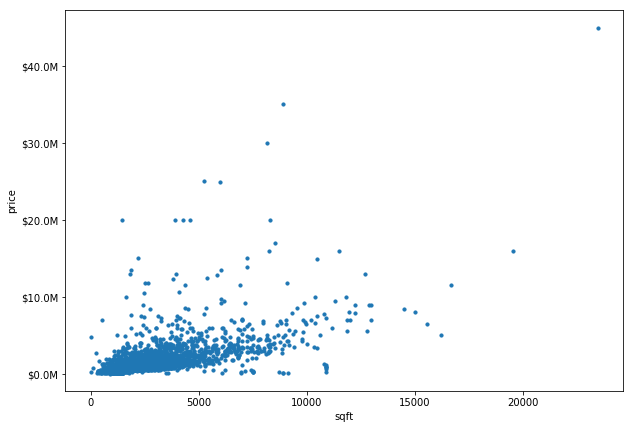

In [17]:
# parallel arrays for plotting
sqfts = []
prices = []
for listing in listings:
    if 'NA' not in [listing['price'], listing['sqft']]:
        sqfts.append(float(listing['sqft']))
        prices.append(float(listing['price']))

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.yaxis.set_major_formatter(FuncFormatter(millions))
plt.scatter(sqfts, prices, s=10)
plt.xlabel('sqft')
plt.ylabel('price')
plt.show()

The result, as expected, is scattered making it diffucult to see the area-price relationship. A handy tool to highlight the relationship is `linear regression`. `linear regression` is the method of approximating a linear relationship between an independent and dependent variable. In human terms, it is the generation of a trent line. The same graph can become a bit easier to understand with said trendline.

y = 671.12 * x + -216,285


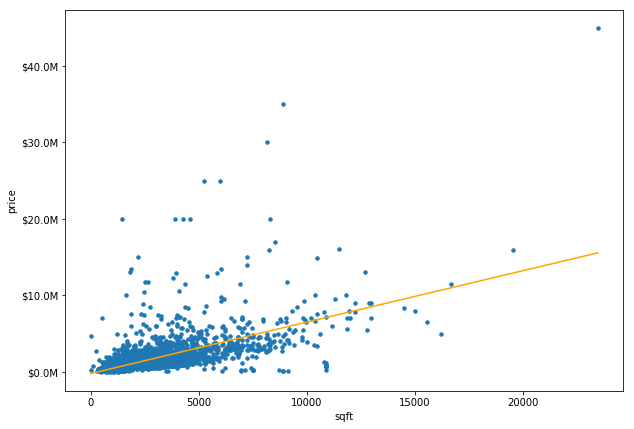

In [18]:
#linear regression
fit = np.polyfit(sqfts, prices, 1)
fit_fn = np.poly1d(fit)


print('y = {:,.2f} * x + {:,.0f}'.format(fit[0], fit[1]))

fig, ax = plt.subplots()
fig.set_size_inches(10, 7)
ax.yaxis.set_major_formatter(FuncFormatter(millions))
plt.scatter(sqfts,prices, s=12)
plt.plot([min(sqfts), max(sqfts)], [fit_fn(min(sqfts)), fit_fn(max(sqfts))],color='orange')
plt.xlabel('sqft')
plt.ylabel('price')
plt.show()

It is now easy to make the conclusion that as the square-footage goes up, so does the price. Visually, the slope of this single trednline does not matter as the scales on the plot can change it. The real use of linear regression is to use the generated function, found abouve the graph. By plugging a square-footage for `x` it is possible to approximate the price of the home. Or by plugging a price for `y`, solving for x will give an approximate size.

These estimates are quite rough, but they can be made more accurate using the methods from the previous section. By splitting sample into groups of zip code, the approximations can be made more accurate. 

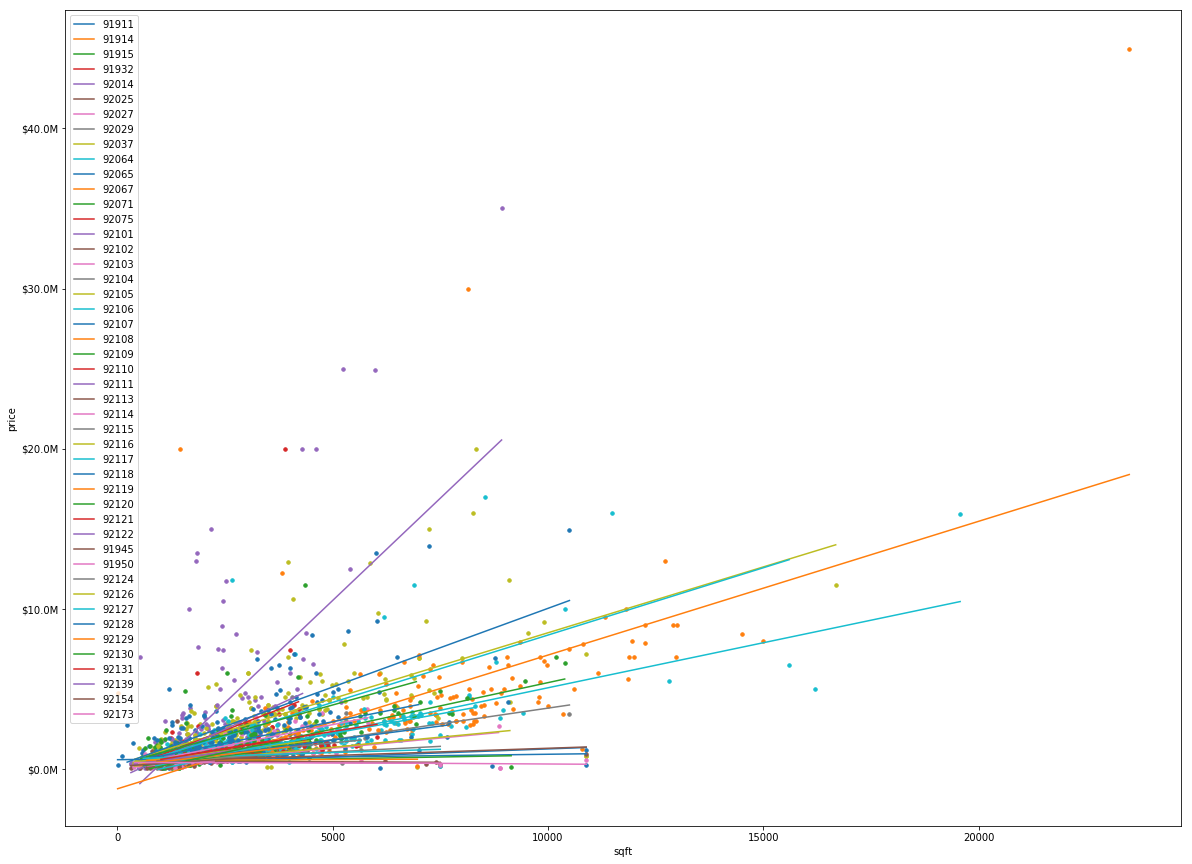

In [19]:
zip_price_sqft_dict = {}

# iterate listings populating lists for each zip code
for listing in listings:
    # filter prices above threshold
    if 'NA' not in [listing['zip'], listing['price'], listing['sqft']]:
        key = listing['zip']
        if key in zip_price_sqft_dict:
            zip_price_sqft_dict[key].append([float(listing['sqft']), float(listing['price'])])
        else:
            zip_price_sqft_dict[key] = [[float(listing['sqft']), float(listing['price'])]]

# format
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(FuncFormatter(millions))
fig.set_size_inches(20, 15)

# plot
for k in zip_price_sqft_dict:
    v = zip_price_sqft_dict[k]
    sqfts, prices = np.array(v).T
    
    fit = np.polyfit(sqfts, prices, 1)
    fit_fn = np.poly1d(fit)
    
    ran = [min(sqfts), max(sqfts)]
    
    plt.scatter(sqfts, prices, s=12)
    plt.plot(ran, fit_fn(ran), label=k)
    

plt.xlabel('sqft')
plt.ylabel('price')
plt.legend()
plt.show()

This plot is a little busy but by looking at the `m` and `b` values being generated a sample group of zip codes can be isolated for readability. We'll do this by listing the `m` and `b`, values as well as average `dollars/sqft`. The averages will be listed because `m` values might mistakenly be thought of as *the* average `dollars/sqtf` because it has the same units. However those numbers will be different.

This is because the linear approximation takes a bias into account. That even if the house has 0 sqft it still has some value. The avarage assumes a linear approximation where the line always crosses the origin.

In [20]:
zip_price_sqft_dict = {}

# iterate listings populating lists for each zip code
for listing in listings:
    # filter prices above threshold
    if 'NA' not in [listing['zip'], listing['price'], listing['sqft']]:
        key = listing['zip']
        if key in zip_price_sqft_dict:
            zip_price_sqft_dict[key].append([float(listing['sqft']), float(listing['price'])])
        else:
            zip_price_sqft_dict[key] = [[float(listing['sqft']), float(listing['price'])]]


i = 0
for k in zip_price_sqft_dict:
    v = zip_price_sqft_dict[k]
    sqfts, prices = np.array(v).T
    
    fit = np.polyfit(sqfts, prices, 1)
    fit_fn = np.poly1d(fit)
    
    print(k, ': y = {:,.2f} \t* x + {:,.0f}'.format(fit[0], fit[1]), '\t\tavg price/sqft: ', (sum(prices)/ sum(sqfts)))

91911 : y = 99.88 	* x + 243,525 		avg price/sqft:  228.759906549
91914 : y = 268.45 	* x + -11,900 		avg price/sqft:  264.983584741
91915 : y = 200.02 	* x + 134,472 		avg price/sqft:  262.209519205
91932 : y = 444.54 	* x + 160,577 		avg price/sqft:  553.876812201
92014 : y = 2,555.48 	* x + -2,268,081 		avg price/sqft:  1721.38070929
92025 : y = 246.26 	* x + 100,502 		avg price/sqft:  291.347165155
92027 : y = 254.69 	* x + 7,600 		avg price/sqft:  258.044043241
92029 : y = 393.06 	* x + -140,967 		avg price/sqft:  343.477533721
92037 : y = 822.47 	* x + 271,299 		avg price/sqft:  904.373779509
92064 : y = 562.63 	* x + -565,924 		avg price/sqft:  415.09621279
92065 : y = 33.94 	* x + 569,138 		avg price/sqft:  267.513500327
92067 : y = 835.56 	* x + -1,252,621 		avg price/sqft:  662.201058836
92071 : y = 47.47 	* x + 381,423 		avg price/sqft:  269.83604824
92075 : y = 1,041.05 	* x + -194,949 		avg price/sqft:  942.504986611
92101 : y = 1,240.36 	* x + -631,551 		avg price/sqft:  

The trimmed list of zip codes will be the max (`92014`), min (`92121`), and two other zip codes in between (`92067`, `92104`).

92014 : y = 2,555.48 	* x + -2,268,081 		avg price/sqft:  1721.38070929
92114 : y = -15.90 	* x + 459,080 		avg price/sqft:  232.293879396
92067 : y = 835.56 	* x + -1,252,621 		avg price/sqft:  662.201058836
92104 : y = 258.42 	* x + 330,008 		avg price/sqft:  489.482392916


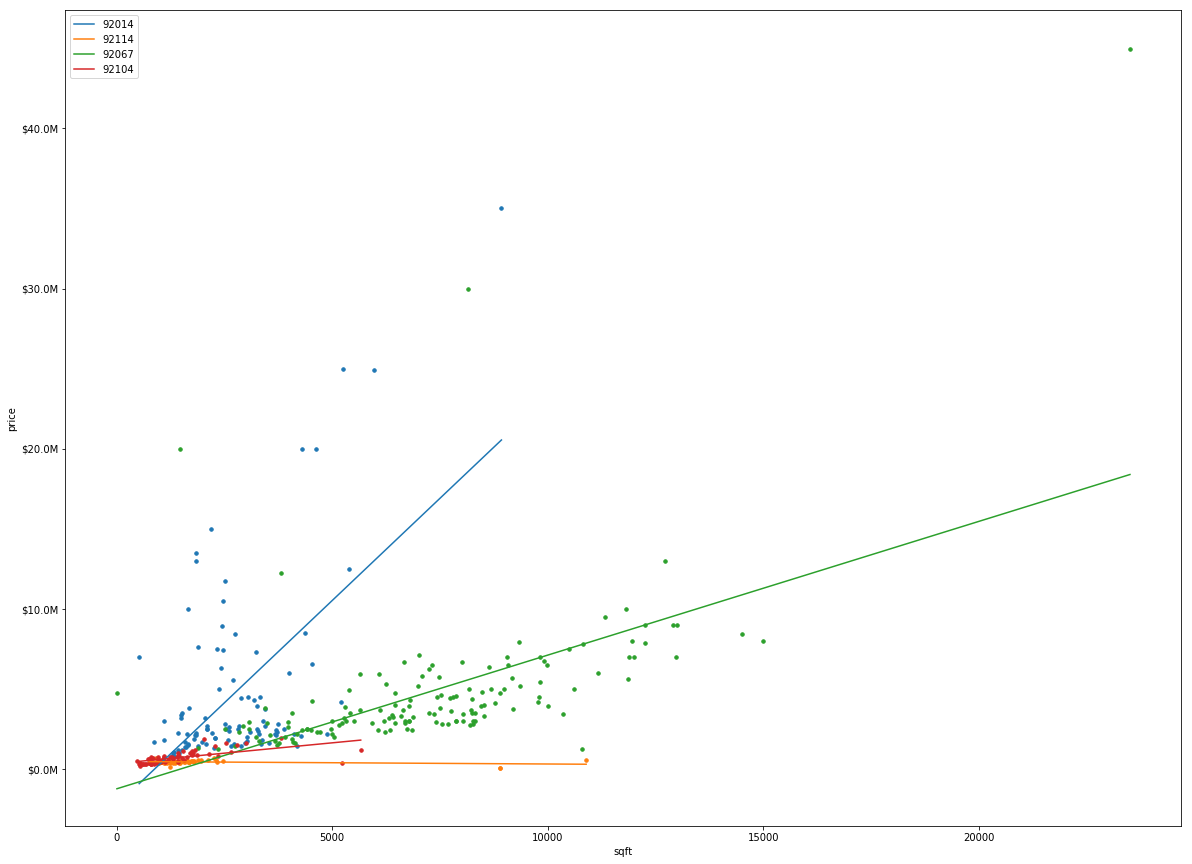

In [21]:
zip_price_sqft_dict = {}

# iterate listings populating lists for each zip code
for listing in listings:
    # filter prices above threshold
    if 'NA' not in [listing['zip'], listing['price'], listing['sqft']]:
        key = listing['zip']
        if key in zip_price_sqft_dict:
            zip_price_sqft_dict[key].append([float(listing['sqft']), float(listing['price'])])
        else:
            zip_price_sqft_dict[key] = [[float(listing['sqft']), float(listing['price'])]]

# format
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(FuncFormatter(millions))
fig.set_size_inches(20, 15)

# plot
for k in ['92014', '92114', '92067', '92104']:
    v = zip_price_sqft_dict[k]
    sqfts, prices = np.array(v).T
    
    fit = np.polyfit(sqfts, prices, 1)
    fit_fn = np.poly1d(fit)

    # print eq
    print(k, ': y = {:,.2f} \t* x + {:,.0f}'.format(fit[0], fit[1]), '\t\tavg price/sqft: ', (sum(prices)/ sum(sqfts)))
    
    ran = [min(sqfts), max(sqfts)]
    
    plt.scatter(sqfts, prices, s=12)
    plt.plot(ran, fit_fn(ran), label=k)
    

plt.xlabel('sqft')
plt.ylabel('price')
plt.legend()
plt.show()

This graph is the most revealing so far but also the most complicated. Let's break it down. There are four different zip codes shown, each with a different color. Each zip code has its raw data points and a trend line. The trend line is a linear funciton which aproximates the price of a house based on its size. Using this graph we can anlyze the metric we've been talking about, `dollars/sqft`, for the four zip codes. when going for size, the best bargains will be in the `92104` and `92114` zip codes. Not only do they have the lowest average `dollars/sqft`, their trendlines are also the flattest. Meaning that size does not effect the price of the homes as much as other neighborhoods. `92114` even has a decreasing trendline, meaning that a bigger home will actually cost less. This could have several causes, due to broad nature of our analysis. We did not filter forclosed homes whose listing is the statrting price of an auction. There are also general and applicable reasons for a flat or negative trendline; if the demographic cannot afford a more expensive home then a bigger house will never sell.

With these things in mind this analysis can be taken one step further by plotting the `dollars/sqft` on the `y-axis`. But first it requires some explanation. Such a graph would tell if the neighborhood values the size of homes. In other words, it will answer the question, "is it a better bargain to buy a bigger or smaller home?"

92014 : y = -0.08 	* x + 1,990 		avg price/sqft:  1721.38070929
92114 : y = -0.04 	* x + 378 		avg price/sqft:  232.293879396
92067 : y = -2.67 	* x + 23,485 		avg price/sqft:  662.201058836
92104 : y = -0.05 	* x + 603 		avg price/sqft:  489.482392916


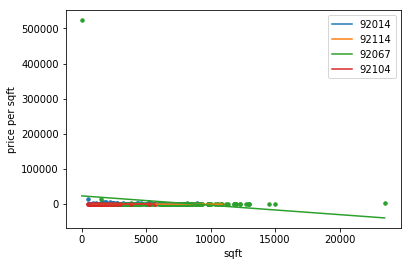

In [22]:
zip_price_sqft_dict = {}

# iterate listings populating lists for each zip code
for listing in listings:
    # filter prices above threshold
    if 'NA' not in [listing['zip'], listing['price'], listing['sqft']]:
        key = listing['zip']
        if key in zip_price_sqft_dict:
            zip_price_sqft_dict[key].append([float(listing['sqft']), float(listing['price'])])
        else:
            zip_price_sqft_dict[key] = [[float(listing['sqft']), float(listing['price'])]]

# plot
for k in ['92014', '92114', '92067', '92104']:
    v = zip_price_sqft_dict[k]
    sqfts, prices = np.array(v).T
    dollar_per_sqft = prices / sqfts
    
    fit = np.polyfit(sqfts, dollar_per_sqft, 1)
    fit_fn = np.poly1d(fit)

    # print eq
    print(k, ': y = {:,.2f} \t* x + {:,.0f}'.format(fit[0], fit[1]), '\t\tavg price/sqft: ', (sum(prices)/ sum(sqfts)))
    
    ran = [min(sqfts), max(sqfts)]
    
    plt.scatter(sqfts, dollar_per_sqft, s=12)
    plt.plot(ran, fit_fn(ran), label=k)
    

plt.xlabel('sqft')
plt.ylabel('price per sqft')
plt.legend()
plt.show()

The oulier makes this graph incomprehensible, but before removing it what does it mean? For starters, that house is outrageoulsly expensve for its size. In the previous graph that datapoint was way above its trendline; that simply meant its price was high compared to other houses with similar sqft. Here the `dollars/sqft` is high compared to every other house in the sample. To get a better picture of the rest of the market this point will have to be ignored.

*the ignored point will be printed to look into why it is outlying*

OrderedDict([('address', '17588 Ranchito Del Rio'), ('city', 'RANCHO SANTA FE'), ('state', 'CA'), ('zip', '92067'), ('price', '4710000'), ('sqft', '9.0'), ('bedrooms', '5.0'), ('bathrooms', '6.5'), ('days_on_zillow', 'NA'), ('sale_type', 'Foreclosed'), ('url', 'http://www.zillow.com/homes/for_sale//homedetails/17588-Ranchito-Del-Rio-Rancho-Santa-Fe-CA-92067/59309155_zpid/')])
92014 : y = -0.08 	* x + 1,990 		avg price/sqft:  1721.38070929
92114 : y = -0.04 	* x + 378 		avg price/sqft:  232.293879396
92067 : y = -0.05 	* x + 1,073 		avg price/sqft:  657.860829674
92104 : y = -0.05 	* x + 603 		avg price/sqft:  489.482392916


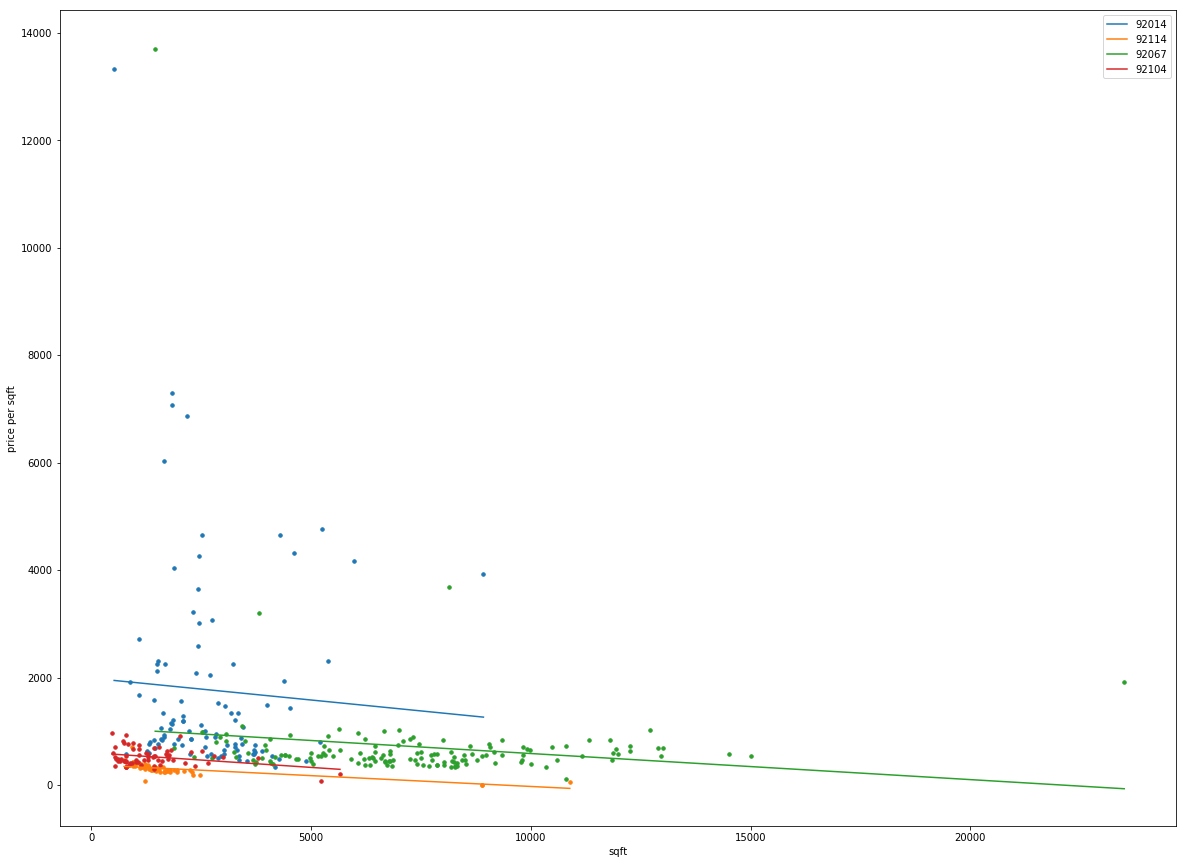

In [23]:
zip_price_sqft_dict = {}

# iterate listings populating lists for each zip code
for listing in listings:
    # filter prices above threshold
    if 'NA' not in [listing['zip'], listing['price'], listing['sqft']]:
        key = listing['zip']
        if float(listing['price'])/float(listing['sqft']) > 1e5:
            print(listing)
            continue
        if key in zip_price_sqft_dict:
            zip_price_sqft_dict[key].append([float(listing['sqft']), float(listing['price'])])
        else:
            zip_price_sqft_dict[key] = [[float(listing['sqft']), float(listing['price'])]]


# format
fig, ax = plt.subplots()
fig.set_size_inches(20, 15)
            
# plot
for k in ['92014', '92114', '92067', '92104']:
    v = zip_price_sqft_dict[k]
    sqfts, prices = np.array(v).T
    dollar_per_sqft = prices / sqfts
    
    fit = np.polyfit(sqfts, dollar_per_sqft, 1)
    fit_fn = np.poly1d(fit)

    # print eq
    print(k, ': y = {:,.2f} \t* x + {:,.0f}'.format(fit[0], fit[1]), '\t\tavg price/sqft: ', (sum(prices)/ sum(sqfts)))
    
    ran = [min(sqfts), max(sqfts)]
    
    plt.scatter(sqfts, dollar_per_sqft, s=12)
    plt.plot(ran, fit_fn(ran), label=k)
    

plt.xlabel('sqft')
plt.ylabel('price per sqft')
plt.legend()
plt.show()

It looks like a data error. The listing states that it has 9 sqft, which upon looking at the pictures in the specified webpage is proven to be false. Use the trendline method above to guess the correct size it might be. The trendline for the outliers zip code was:

$$y = 835.56 * x - 1,252,621$$

Pluggin in `y` and solving for `x` gives : 7136.08. With the incorrect 9 value an assumption can be made that the agent mistyped the listing and likely meant to put 9000.

Now, back to the graph. The general trend is that each sqft becomes cheaper as the house gets bigger. This is a generally accepted fact of economics and can be summarized as "the more you get, the more you get".

The data for `92014` is quite scattered with many ouliers above the trendline. This means that the sqft can have a very high price in the zip code, presumibly due to some extraneous quality (ie. recently remodeled, high demand location, distance from neighbors, etc.) Above we found that this zip code is for the city of Del Mar, which lies directly on the coast. Now, we can assume that the extraneous quality might be ocean views, or beach front location. While such a thing is obvious, we can now see data supporting the existance of a the so called *beach tax*.

## Conclusion

The most prominent fact is that there is a very large range of prices on homes for sale in San Diego. This large range plaugued most visualizations forcing a trim in the dataset to get a clear picture of the core body of data. Del mar can be seen as the wild west of real estate with a large potential for profit regardless of home size. Inland expensive neighborhoods, such as Rancho Santa Fe, do not have the same potential. Also, not even Del Mar is free from the economics rule of "cheaper in bulk".

# Appendix

* Data retrived from https://zillow.com for full data file here https://github.com/ear7h/sd_housing/blob/master/composition.csv

* Calculations and data modeling done with python 3
* Visualizations created with python's matplotlib

In [24]:
i = 0
for listing in listings:
    print(listing, '\n')
    i = i + 1
    if i > 5:
        print('...')
        break
    

OrderedDict([('address', '502 Anita Street 36 # 36'), ('city', 'Chula Vista'), ('state', 'CA'), ('zip', '91911'), ('price', '179900'), ('sqft', '1474.0'), ('bedrooms', '3.0'), ('bathrooms', '2.0'), ('days_on_zillow', 'NA'), ('sale_type', 'Home For Sale'), ('url', 'http://www.zillow.com/homes/for_sale//homedetails/502-Anita-Street-36-36-Chula-Vista-CA-91911/2092992516_zpid/')]) 

OrderedDict([('address', '29 E Naples St'), ('city', 'Chula Vista'), ('state', 'CA'), ('zip', '91911'), ('price', '445000'), ('sqft', '1050.0'), ('bedrooms', '3.0'), ('bathrooms', '2.0'), ('days_on_zillow', 'NA'), ('sale_type', 'House For Sale'), ('url', 'http://www.zillow.com/homes/for_sale//homedetails/29-E-Naples-St-Chula-Vista-CA-91911/17110966_zpid/')]) 

OrderedDict([('address', '1100 Industrial Blvd SPC I33'), ('city', 'Chula Vista'), ('state', 'CA'), ('zip', '91911'), ('price', '69900'), ('sqft', '1200.0'), ('bedrooms', '2.0'), ('bathrooms', '2.0'), ('days_on_zillow', 'NA'), ('sale_type', 'Home For Sale